In [ ]:
from nbdev import *
from utilities.ipynb_docgen import *
%nbdev_default_export simulation
%load_ext autoreload
%autoreload 2

Cells will be exported to wtlike.simulation,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Simulation
> Generate simulated cells using the weighted likelihood

For simulation the distribution of weights is required. That can be a histogram or a function, an input to the `_WeightGenerator` class. The class is a functor, with the argument a number on the range (0,1).  Passing an array of uniform random numbers then creates set of weights distributed according to the model represented by the input weight distribution.

To account for different levels of signal or background than that represented by the full dataset, the `_WeightGenerator` class accepts `alpha` and `beta` parmeters, which will be used to weight the weight distribution  by a factor

$$ \big(1 + \alpha w + \beta \ (1-w)\ \big) $$

Generating a cell requires also the expected number of photons. If the average flux and exposure predict a number of events $\mu$, we select the actual number from the Poisson distribution. 

This is done by `generate_cell`, which creates a list of weights depending on $\alpha$, $\beta$, and $\mu$. 

Finally, `simulate_cells` makes a list of cells, based on the actual exposure of a source.


In [ ]:
%nbdev_export
import os
import numpy as np
import pandas as pd
from scipy import stats

from wtlike.config import *
from wtlike.loglike import *
from wtlike.exposure import *
from wtlike.cells import *
from wtlike.lightcurve import *
from wtlike.weights import get_weight_hist

In [ ]:
%nbdev_export
import numbers

class _Sampler():
    """ Sample an arbitrary function or histogram
    
    - func -- a function, a histogram, or a fixed value<br>
        If a function, must be positive definite.<br>
        Assume histogram bins are 0 to 1.
    - a,b  -- limits (default 0,1)
    - n    -- table size (ignored if a histogram or value)
    
    """
     
    def __init__(self, func, limits=(0,1), n=100):

        a,b = limits
        self.x = np.linspace(a,b,n+1) # bin edges
        dx = (b-a)/(n)/2
        self.deltafun=None

        if callable(func):
            # A function
            # evaluate at bin centers
            y = np.array([func(t-dx) for t in self.x])
            if np.any(y<0) or np.sum(y)==0:
                raise ValueError('Function is not positive definite')
        elif isinstance(func, numbers.Number):
            # a single value, or delta function
            self.deltafun = func
            if  func<0 or func>1:
                raise ValueError('Value not in range [0,1]')
            self.mean=func
            return
        else:
            n = len(func) 
            self.x = np.linspace(a,b,n)
            y = func
        cy = np.cumsum(y)
        d = cy[-1]-cy[0]
        self.sy = (cy-cy[0])/d
        
        self.mean = np.sum( (self.x-dx) * y) / d

    def _evaluate(self, r):
        """evaluate inverse integral. expect 0<r<1 """
        return np.interp(r, self.sy, self.x)
    
    def __call__(self, size):
        """Generate `size` values
        """
        if self.deltafun: return np.full(size, self.deltafun)
 
        return self._evaluate(stats.uniform.rvs(size=size))

In [ ]:
from wtlike.simulation import _WeightGenerator, _Sampler
show_doc(_Sampler, title_level=2)

<h2 id="_Sampler" class="doc_header"><code>class</code> <code>_Sampler</code><a href="https://github.com/tburnett/wtlike/tree/master/wtlike/simulation.py#L21" class="source_link" style="float:right">[source]</a></h2>

> <code>_Sampler</code>(**`func`**, **`limits`**=*`(0, 1)`*, **`n`**=*`100`*)

Sample an arbitrary function or histogram

- func -- a function, a histogram, or a fixed value<br>
    If a function, must be positive definite.<br>
    Assume histogram bins are 0 to 1.
- a,b  -- limits (default 0,1)
- n    -- table size (ignored if a histogram or value)

###   Gaussian and quadratic example functions


In [ ]:
%nbdev_collapse_input
n = 20
sf = _Sampler(lambda x: np.exp(-(x**2)/2), limits=(-4, 4) )

data = sf(10000)
tests = np.array([np.abs(data.mean()), np.abs(data.std()-1) ])
assert np.all(tests<5e-2 ), f'Failed Tests: mean {data.mean()}, std {data.std()}'

func = lambda x: x**2
wfun = _Sampler(func)

test2 = wfun.mean,  np.mean(wfun(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

### Use a  histogram

In [ ]:
from wtlike.source_data import *
config = Config(data_folder='/home/burnett/weekly', verbose=2)
source = PointSource('Geminga')
sd = SourceData(config, source); sd

photons and exposure for Geminga: Restoring from cache with key "Geminga_weekly_data"


SourceData: Source Geminga with:
	 data:     2,381,241 photons from   2008-08-04 to 2021-04-22
	 exposure: 3,106,496 intervals from 2008-08-04 to 2021-04-22

In [ ]:
self=sd
nbins=50
np.histogram(self.p_df.weight.values, np.linspace(0,1,nbins+1))[0]

array([ 76196,  49374,  36838,  35817,  29239,  27614,  27018,  23363,
        16153,  21891,  20818,  14583,  21031,  12904,  11575,  13903,
        15386,  13518,  13428,  12146,  16433,  11605,  14782,  10378,
        16876,  10088,  10985,   8734,  20185,  20890,  12759,  26453,
        16459,  36519,   9818,  15488,  41751,  12771,  26995,  58443,
        25703,  72872,  66044,  57439,  14731,  69507, 126686,  76965,
       128716,      0])

photons and exposure for Geminga: Restoring from cache with key "Geminga_weekly_data"


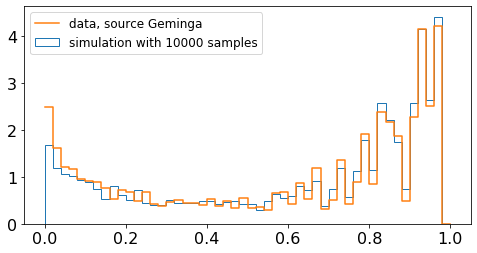

In [ ]:
#
from wtlike.weights import *
config = Config(data_folder='/home/burnett/weekly', verbose=2)
if config.valid:
    plt.rc('font', size=16)
    source = PointSource('Geminga')
    photon_data = SourceData(config, source)
    h = photon_data.weight_histogram()
    sf = _Sampler(h)
    data = sf(10000)
    fig,ax = plt.subplots(figsize=(8,4))
    ax.hist(data, np.linspace(0,1, len(h)+1), density=True, 
            label=f'simulation with {len(data)} samples');
    ax.step( np.linspace(0,1, len(h)+1) , np.concatenate([[h[0]], h])/np.sum(h)*len(h),
           label=f'data, source {source.name}');
    ax.legend(prop=dict(size=12));

In [ ]:
%nbdev_export
class _WeightGenerator(_Sampler):
    """Generate a set of weights
    
    - `func` -- nominal weight distribution function, evaluated on (0,1)
    - `alpha, beta` -- (default 0,0). Values for $\\alpha$, $\\beta$.
    
    """
    def __init__(self, func, alpha=0, beta=0, n=100):
        if alpha==0 and beta==0:
            fprime = func
        else:
            # weight the function
            fprime = lambda w: func(w) * ( 1 + alpha*w + beta*(1-w) )
        super().__init__( fprime, limits=(0,1),  n=n)
  

In [ ]:

show_doc(_WeightGenerator, title_level=2)

<h2 id="_WeightGenerator" class="doc_header"><code>class</code> <code>_WeightGenerator</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>_WeightGenerator</code>(**`func`**, **`alpha`**=*`0`*, **`beta`**=*`0`*, **`n`**=*`100`*) :: `_Sampler`

Generate a set of weights

- `func` -- nominal weight distribution function, evaluated on (0,1)
- `alpha, beta` -- (default 0,0). Values for $\alpha$, $\beta$.

### Test

In [ ]:
wg = _WeightGenerator(func)
test2 = wg.mean,  np.mean(wg(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

In [ ]:
%nbdev_export
def generate_cell(wfun, mu, alpha=0, beta=0):
    """ Generate a cell

    - `wfun` -- weight function, or histogram. 
        Defined on (0,1)
    - `mu` -- number of expected weights, on average
    - `alpha`, `beta`  -- default 0,0; values for $\\alpha$ and  $\\beta$ for this cell 
    
    Returns a dict with:
    - `n` -- actual generated number of weights, from Poisson 
    - `w` -- array of weights 
    - `S, B` -- expected values for $\sum w$ and $\sum(1-w)$, calulated from wfun
    """
    

    wgen_nominal = _WeightGenerator(wfun)
    wgen_cell =wgen_nominal if alpha==0 and beta==0 else _WeightGenerator(wfun, alpha, beta)
    
    # adjust expected number of events:
    wbar = wgen_nominal.mean
    mu_cell = mu * (1+alpha*wbar+beta*(1-wbar))
   
    # the weight array
    n = stats.poisson.rvs(mu_cell )    
    w = wgen_cell(n)
    
    S = wgen_nominal.mean * mu
    B = mu-S
    
    return dict(
        n=n,
        w=np.array(w, np.float32), #np.uint8),
        S=S,
        B=B,
    )

In [ ]:

show_doc(generate_cell)

<h4 id="generate_cell" class="doc_header"><code>generate_cell</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>generate_cell</code>(**`wfun`**, **`mu`**, **`alpha`**=*`0`*, **`beta`**=*`0`*)

Generate a cell

- `wfun` -- weight function, or histogram. 
    Defined on (0,1)
- `mu` -- number of expected weights, on average
- `alpha`, `beta`  -- default 0,0; values for $\alpha$ and  $\beta$ for this cell 

Returns a dict with:
- `n` -- actual generated number of weights, from Poisson 
- `w` -- array of weights 
- `S, B` -- expected values for $\sum w$ and $\sum(1-w)$, calulated from wfun

Test with a function peaked at both ends, generate equal signal and background

In [ ]:
#collapse_hide
def test_gen(alpha, beta, mu=10000, tol=3, quiet=True):
    wfun = lambda x: (x-0.5)**2
    pd.set_option('display.precision', 3)
    if not quiet: print(f'Test with alpha={alpha}, beta={beta}')
    cell = generate_cell( wfun, mu,  alpha, 0 if beta is None else beta)
    #
    ll = LogLike(cell); 
    if not quiet: print(f'Generated cell info:\n{ ll}')

    fit = ll.fit_info(beta is None )
    if not quiet: print(f'{2 if beta is not None else 1}-D fit info:\n{pd.Series(fit)}')
    t, sigt = fit['flux']-(1+alpha),  fit['sig_flux']
    check_alpha = '' if  np.abs(t)<tol*sigt else f'alpha: abs({t:.3f}) > {tol} * {sigt:.3f}'

    if beta is None:
        assert not bool(check_alpha), f'Failed: {check_alpha} '
    else:
        t, sigt = fit['beta']-beta, fit['sig_beta']
        check_beta ='' if np.abs(t)<tol*sigt else f'beta: abs({t:.3f}) > {tol} * {sigt:.3f}'

        assert not ( bool(check_alpha)  or bool(check_beta)), f'{check_alpha}  {check_beta}'
test_gen(0,None)
test_gen(10,None)
#test_gen(10, 0, tol=5, quiet=False)
test_gen(0,2)
test_gen(0.1, None, quiet=False)

Test with alpha=0.1, beta=None
Generated cell info:
wtlike.loglike.LogLike:  10402 weights, S 4998.5, B 5001.5
1-D fit info:
counts      10402.000
flux            1.092
sig_flux        0.016
dtype: float64


In [ ]:
sd = SourceData(config, source)

photons and exposure for Geminga: Restoring from cache with key "Geminga_weekly_data"


In [ ]:
sd.binned_exposure()

Time bins: 4643 intervals of 1 days, from MJD 54683.0(2008-08-05) to 59326.0(2021-04-22))
Relative exposure per bin:
count    4643.000
mean        1.000
std         0.353
min         0.000
50%         0.993
max         3.664
dtype: float64


(array([1.27925282, 1.23016514, 1.19682299, ..., 1.21707418, 1.1495392 ,
        1.18031339]),
 array([54683., 54684., 54685., ..., 59324., 59325., 59326.]))

In [ ]:
%nbdev_export
def simulate_cells(source_data, wdist=None, source_flux=lambda t: 100):
    """
    
    - `source_data` -- a SourceData object, use to get exposure at its position and weight distribution
    - `wdist`   -- a weight function or histogram; if None, get the source distribution
    - `source_flux` -- function of MJD time for the counts/day; default 100/day

    """
    fexp, bins = source_data.binned_exposure()
    
    cells=[]
    wdist = wdist or source_data.weight_histogram()
    for i, e in enumerate(fexp):
        a,b = bins[i:i+2]
        t, tw = (a+b)/2, b-a
        mu = source_flux(t)*tw *e

        cell = dict(t=t, tw=tw, e=e)
        cell.update(generate_cell(wdist, mu))

        cells.append(cell)
    return pd.DataFrame(cells)

In [ ]:
show_doc(simulate_cells, title_level=2)

<h2 id="simulate_cells" class="doc_header"><code>simulate_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>simulate_cells</code>(**`source_data`**, **`wdist`**=*`None`*, **`source_flux`**=*`'<lambda>'`*)

- [`source_data`](wtlike/source_data) -- a SourceData object, use to get exposure at its position and weight distribution
- `wdist`   -- a weight function or histogram; if None, get the source distribution
- `source_flux` -- function of MJD time for the counts/day; default 100/day

In [ ]:
%nbdev_hide
def local_sim_cells(wfun, mu, alpha, N):
    sims = [generate_cell( wfun, mu ,alpha) for i in range(N)]
    fits = [PoissonRep(LogLike(cell )) for cell in sims]
    return sims, fits

In [ ]:
%nbdev_collapse_input
simcells = pfits = None
def simulation_test(N=10000, mu=100, alpha=2, funstr='(x-0.5)**2'):
    """
    ### Test the cell creation
    
    Generate {N:,} cells with mu={mu}, alpha={alpha} using the function {funstr}

    The deviations from the expected norm divided by each cell's average error:
    {fig1}
    Mean and STD of this distribution: {m:.3f}, {sig:.3f}: for a generated Gaussian distribution these wouild be 0 and 1. 
    
    A validation of the shape is to evaluate the cumulative probability of the over-all mean
    for each likelihood function. This uses the `poisson.Poisson.cdf` function.
    {fig2}
    
    """
    global simcells, pfits

    wfun = eval(f'lambda x: {funstr}')
    simcells, pfits =  local_sim_cells(wfun, mu, alpha, N)
    flux = np.array([p.flux for p in pfits]); 
    fmean = 1+alpha
    def pull(p):
        f, (l, h)  = p.flux, p.errors
        s = (h-l)/2
        return (f-fmean)/s
    pulls = np.array(list(map(pull, pfits)))
    
    m, sig = pulls.mean(), pulls.std()

    plt.rc('font', size=18)
    fig1,ax1 = plt.subplots(figsize=(4,3), num=1)
    ax1.hist(pulls, np.linspace(-5, 5, 21), lw=2, histtype='step', log=True);
    ax1.set(ylim=(0.8,None), xlabel='pull'); 
    ax1.grid(alpha=0.5)
    fig1.width=300

    class CDF():
        def __init__(self, alpha):
            self.f = 1+alpha
        def __call__(self, p):
            return p.poiss.cdf(self.f)
        
    def cdf(p, fmean=1.1):
        return p.poiss.cdf(fmean)

    #
    cd = np.array(list(map(CDF(alpha), pfits)))
    fig, ax = plt.subplots(figsize=(5,3), num=2)
    ax.hist(cd, np.linspace(0,1,21), histtype='step', lw=2)
    ax.set(xlabel='probability')
                            
    fig2 = figure(fig, width=300)
    return locals()

if config.valid:
    nbdoc(simulation_test,mu=50, alpha=0)

### Test the cell creation

Generate 10,000 cells with mu=50, alpha=0 using the function (x-0.5)**2

The deviations from the expected norm divided by each cell's average error:
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/simulation_test_fig_01.png" title="images/simulation_test_fig_01.png">    <img src="images/simulation_test_fig_01.png" alt="Figure 1 at images/simulation_test_fig_01.png" width=300>   </a> </figure>
</div>

Mean and STD of this distribution: -0.095, 1.038: for a generated Gaussian distribution these wouild be 0 and 1. 

A validation of the shape is to evaluate the cumulative probability of the over-all mean
for each likelihood function. This uses the `poisson.Poisson.cdf` function.
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 3">  <a href="images/simulation_test_fig_03.png" title="images/simulation_test_fig_03.png">    <img src="images/simulation_test_fig_03.png" alt="Figure 3 at images/simulation_test_fig_03.png" width=300>   </a> </figure>
</div>



#### Follow-on: combine the cells and fit the result

Concatenated cell:
n                                               500261
S                                              2.5e+05
B                                              2.5e+05
w    [0.12062868, 0.11922542, 0.04588856, 0.9908665...
dtype: object
wtlike.loglike.LogLike:  500261 weights, S 249923.5, B 250076.5 
Fit:  {'counts': 500261, 'flux': 1.0018, 'sig_flux': 0.0022}


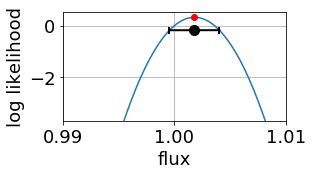

In [ ]:
%nbdev_hide
if config.valid:
    csimcell = concatenate_cells(pd.DataFrame(simcells))
    print(f'Concatenated cell:\n{pd.Series(csimcell)}')

    ll = LogLike(csimcell); 
    print(ll,'\nFit: ', ll.fit_info())
    ll.plot(xlim =(0.99, 1.01))

In [ ]:
%nbdev_collapse_input
cells=[]
def simulation_lightcurve_demo(source_data):
    """
    ### Lightcurve generation test
    
    This uses the exposure measured for the source {source_name}, and
    the default time bins to create a light curve assuming a fixed flux
    and a histogram of weights from the data.
    {output}
    
    {fig}
    """
    global cells
    
    with capture_print('Print out') as output:
        cells =  simulate_cells(source_data, source_flux=lambda t: 100)
        fits =  fit_cells(source_data.config, cells)
        fig = figure(flux_plot(config, fits), width=500)
    
    return locals()

if config.valid:
    nbdoc(simulation_lightcurve_demo, SourceData(config, PointSource('Geminga')))

photons and exposure for Geminga: Restoring from cache with key "Geminga_weekly_data"


### Lightcurve generation test

This uses the exposure measured for the source {source_name}, and
the default time bins to create a light curve assuming a fixed flux
and a histogram of weights from the data.
<details  class="nbdoc-description" >  <summary> Print out </summary>  <div style="margin-left: 5%"><pre>Time bins: 4643 intervals of 1 days, from MJD 54683.0(2008-08-05) to 59326.0(2021-04-22))<br>Relative exposure per bin:<br>count    4643.000<br>mean        1.000<br>std         0.353<br>min         0.000<br>50%         0.993<br>max         3.664<br>dtype: float64<br>Loaded 4443 / 4643 cells with exposure &gt; 0.3 for fitting<br></pre></div> </details>

<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/simulation_lightcurve_demo_fig_01.png" title="images/simulation_lightcurve_demo_fig_01.png">    <img src="images/simulation_lightcurve_demo_fig_01.png" alt="Figure 1 at images/simulation_lightcurve_demo_fig_01.png" width=500>   </a> </figure>
</div>



In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_gti.ipynb.
Converted 02_source_data.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cell_data.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Sun Apr 25 15:14:58 PDT 2021


In [ ]:
cd